<a href="https://colab.research.google.com/github/evysb/RL_in_stock_trading/blob/main/RL_in_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

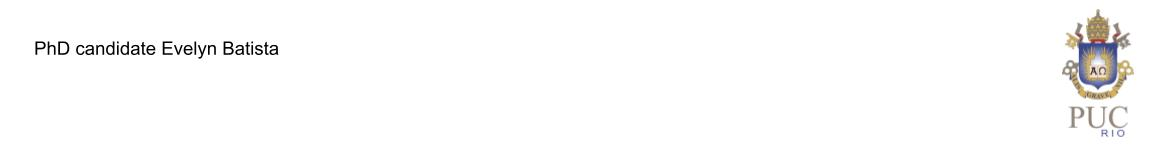

O material neste repositório são scripts do Professor Jones Granatyr modificador por mim.

## Instalar bibliotecas e montar drive do Google Drive

In [ ]:
!pip install tensorflow==2.12.0rc0 #2.8.0

In [ ]:
!pip show tensorflow

In [ ]:
!pip install pandas-datareader==0.10.0
!pip install yfinance==0.2.3
'''
CLICAR em restart runtime depois da instalação!!
'''

### Tem algumas explicações de RL em negociação de ações aqui:

https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/

Mas o código não é o mesmo!!

In [ ]:
# Montar drive no google drive!
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive'
os.chdir(workdir_path)
os.mkdir("models_rl")
os.chdir('/content/drive/My Drive/models_rl')

Mounted at /content/drive


FileExistsError: [Errno 17] File exists: 'models_rl'

In [ ]:
os.chdir('/content/drive/My Drive/models_rl')

## Importar das bibliotecas

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader # usado para nao ter que baixar o csv
#from pandas.util.testing import assert_frame_equal
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yfin


yfin.pdr_override()

from tqdm import tqdm_notebook, tqdm
from collections import deque

<ipython-input-4-e7feebe2a320>:8: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
print("versão do TF ",tf.__version__)
print("versão do Pandas ",pd.__version__)
print("versão do pandas_datareader ", data_reader.__version__)

'''
versão do TF  2.8.0
versão do Pandas  1.3.3
versão do pandas_datareader  0.10.0
'''

versão do TF  2.8.0
versão do Pandas  1.3.3
versão do pandas_datareader  0.10.0


## Criação das funções que usaremos para treinar o modelo

In [ ]:
class Agent():

  def __init__(self, state_size, action_space = 3, continue_training=False):
    self.state_size = state_size #depende do tamanho da janela (window_size)
    self.action_space = action_space #acoes: compra, venda, faz nada
    self.memory = deque(maxlen = 2000)
    self.gamma = 0.95 #0.9
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995
    self.model = self.get_model()

  '''
    Política
  '''
  def trade(self, state): #função que vai fazer a negociação, vai retornar as ações
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space) # no inicio será aleatório

    actions = self.model.predict(state) #depois usará as predição da rede
    return np.argmax(actions[0])

  '''
    Cria a rede e compila - pode mudar conforme o necessário
  '''
  def get_model(self):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units = 16, activation = "relu", input_dim = self.state_size))
    model.add(tf.keras.layers.Dense(units = 32, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = 64, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = self.action_space, activation = "linear"))
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(lr = 0.001))
    return model

  '''
    Treinamento da rede
  '''
  def train_on_batch(self, batch_size):
    batch = []
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)): #pega as ultimas transações da memória
      batch.append(self.memory[i])

    for state, action, reward, next_state, done in batch:
      if not done:
        #Faz previsoes para o próximo estado
        #self.model.predict(next_state)[0] -> valores de Q no estado next_state
        #np.amax(self.model.predict(next_state)[0]) #busca ql maior valor de Q(s,a), ou seja, ql maior R
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0]) #Eq Bellman

      target = self.model.predict(state)
      target[0][action] = reward #associa a ação que levou a ter a reward calculada

      self.model.fit(state, target, epochs=3, verbose=0) #TODO mudar ep

    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay


## Análise e pré-processamento da base de dados

#### Sigmoid

usado para normalizar entre 0 e 1

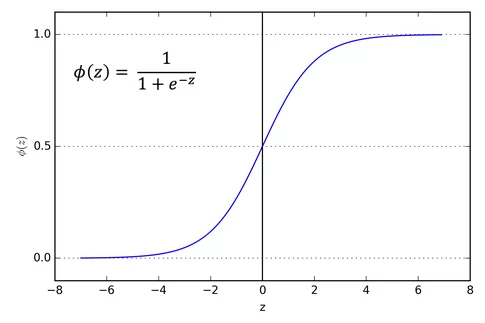

In [ ]:
def sigmoid(z):
  return 1 / (1 + math.exp(-z))

In [ ]:
sigmoid(0.5)

0.6224593312018546

#### Formatação de preços

verifica se está tendo lucro ou não e formata (deixa bonitinho)

In [ ]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

In [ ]:
stocks_price_format(100)

'$ 100.000000'

#### Análise e criação da função de carregar a base de dados

In [ ]:
import yfinance as yf

# Baixar dados sem especificar intervalo
dataset_total = yf.download("AAPL", period="5y")  # Últimos 5 anos de dados

[*********************100%***********************]  1 of 1 completed


In [ ]:
#pega só 1000 dados para treino e teste
dataset = dataset_total[:1000]
dataset_test = dataset_total[1000:]

In [ ]:
'''
Quais dados temos:
Date - data
High - maior preço foi vendido no dia
Low - menor preço foi vendido no dia
Open - valor de abertura, qto que a ação valia no inicio do dia
Close	- valor de fechamento,  qto que a ação foi vendida no final do dia
Volume - volume de ações que foram transacionadas nesse dia
Adj Close - qto que valeria a ação considerando dividendos e outros fatores

****AGORA so vamos utilizar apenas o close
'''
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-01,27.592501,27.735001,27.257500,27.372499,25.377876,148347600
2016-12-02,27.292500,27.522499,27.212500,27.475000,25.472906,106112000
2016-12-05,27.500000,27.507500,27.062500,27.277500,25.289795,137298000
2016-12-06,27.375000,27.590000,27.297501,27.487499,25.484493,104782000
2016-12-07,27.315001,27.797501,27.290001,27.757500,25.734819,119994800


In [ ]:
str(dataset.index[0]).split()[0]

'2016-12-01'

In [ ]:
dataset.index[-1]

Timestamp('2020-11-19 00:00:00')

In [ ]:
dataset['Close']

,Close
Date,
2016-12-01,27.372499
2016-12-02,27.475000
2016-12-05,27.277500
2016-12-06,27.487499
2016-12-07,27.757500
...,...
2020-11-13,119.260002
2020-11-16,120.300003
2020-11-17,119.389999


In [ ]:
def dataset_loader(dataset):
  #TODO pegar outros além do Close
  close = dataset['Close']
  return close

### Criador de estados - com janelamento

In [ ]:
0 - 5 + 1

-4

In [ ]:
20 - 5 + 1

16

In [ ]:
dataset[16:21]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-23,28.897499,29.129999,28.897499,29.129999,27.007307,56998000
2016-12-27,29.129999,29.450001,29.122499,29.315001,27.178827,73187600
2016-12-28,29.379999,29.504999,29.049999,29.190001,27.062935,83623600
2016-12-29,29.112499,29.277500,29.100000,29.182501,27.055983,60158000
2016-12-30,29.162500,29.299999,28.857500,28.955000,26.845058,122345200


In [ ]:
#vai fazer D - D' para capturar a tendencia, se sobe ou não o número
#se identifica que a tendencia é subir o preço, o agente nao vai comprar

'''
        state                       target
[30.2 , 32.4 , [...], 40.7 , 53.5] [46.1]
subtraindo...
32.4 - 30.2 = 2.2
32.4 - ... = ...
53.5 - 40.7 = 12.8
'''

def state_creator(data, timestep, window_size):
  starting_id = timestep - window_size + 1 # da onde vai começar a pegar os dados na base

  if starting_id >= 0:
    windowed_data = data[starting_id:timestep + 1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep + 1]) #vai repetir os valores de starting_id for negativo

  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i + 1] - windowed_data[i])) #normaliza dos dados e os subtrai

  return np.array([state]), windowed_data

### Loading da base de dados

In [ ]:
data = dataset_loader(dataset) #LEMBRANDO: so tem close!

In [ ]:
data_test = dataset_loader(dataset_test) #so tem close!

In [ ]:
s, w = state_creator(data, 0, 5)

In [ ]:
s

array([[0.5, 0.5, 0.5, 0.5]])

In [ ]:
w

[27.372499465942383,
 27.372499465942383,
 27.372499465942383,
 27.372499465942383,
 27.372499465942383]

## Fase de Treinamento:

### Configuração dos hyper parâmetros

In [ ]:
window_size = 10 #com 10 numeros, quer prever se compra ou nao
episodes = 1 #AUMENTAR
batch_size = 32
data_samples = len(data) - 1
data_samples_test = len(data_test) - 1

### Modelo

In [ ]:
agent = Agent(window_size)

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,027
Trainable params: 3,027
Non-trainable params: 0
_________________________________________________________________


### Treinamento:

In [ ]:
for episode in range(1, episodes + 1):
  print("Episode: {}/{}".format(episode, episodes))
  state = state_creator(data, 0, window_size + 1)[0]
  total_profit = 0
  agent.inventory = []
  for t in tqdm(range(data_samples)):
    action = agent.trade(state)
    next_state = state_creator(data, t + 1, window_size + 1)[0]
    reward = 0

    if action == 1: # Comprando uma ação
      agent.inventory.append(data[t])
      print("Agent bought: ", stocks_price_format(data[t]))
    elif action == 2 and len(agent.inventory) > 0: # Vendendo uma ação, dado que so posso vender se ja comprei algo!
      buy_price = agent.inventory.pop(0) #remove 1 item da pilha e pega o preço que foi pago

      reward = max(data[t] - buy_price, 0) #valor atual da ação - valor pago #MAX pra não deixar recompensa negativa! (Pode ser modificado!)
      total_profit += data[t] - buy_price
      print("Agent sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price))

    if t == data_samples - 1:
      done = True
    else:
      done = False

    agent.memory.append((state, action, reward, next_state, done))

    state = next_state

    if done:
      print("######## DONE ########")
      print("-- [INFO] Total profit: ", total_profit)

    if len(agent.memory) > batch_size:
      agent.train_on_batch(batch_size)

  #if episode % 10 == 0:
  agent.model.save("model_{}.h5".format(episode)) #Salvando arquitetura e pesos!


Episode: 1/1


  0%|          | 0/999 [00:00<?, ?it/s]

Agent bought:  $ 27.372499
Agent bought:  $ 27.475000
Agent bought:  $ 27.277500
Agent bought:  $ 27.487499
Agent sold:  $ 27.757500  Profit: $ 0.385000
Agent bought:  $ 28.487499
Agent bought:  $ 28.325001
Agent sold:  $ 28.797501  Profit: $ 1.322500
Agent sold:  $ 28.992500  Profit: $ 1.715000
Agent bought:  $ 29.160000
Agent bought:  $ 29.237499
Agent sold:  $ 29.264999  Profit: $ 1.777500
Agent sold:  $ 29.072500  Profit: $ 0.585001
Agent bought:  $ 29.190001
Agent sold:  $ 29.182501  Profit: $ 0.857500
Agent bought:  $ 28.955000
Agent sold:  $ 29.037500  Profit: - $ 0.122499
Agent sold:  $ 29.004999  Profit: - $ 0.232500
Agent bought:  $ 29.152500
Agent bought:  $ 29.747499
Agent sold:  $ 29.777500  Profit: $ 0.587500
Agent sold:  $ 29.937500  Profit: $ 0.982500
Agent sold:  $ 29.812500  Profit: $ 0.660000
Agent bought:  $ 29.760000
Agent sold:  $ 29.997499  Profit: $ 0.250000
Agent bought:  $ 29.945000


  3%|▎         | 33/999 [00:04<02:06,  7.62it/s]

Agent sold:  $ 30.000000  Profit: $ 0.240000


  3%|▎         | 33/999 [00:05<02:43,  5.89it/s]


KeyboardInterrupt: 

# Inferência

In [ ]:
model = tf.keras.models.load_model("model_1.h5")

In [ ]:
for t in tqdm(range(data_samples_test)):
  state = state_creator(data_test, t + 1, window_size + 1)[0]
  print(state)
  action = model.predict(state)
  result = np.argmax(action[0])
  print("result ", result)

  if result == 1:
    print("-- [INFO] bought!")
  elif result == 2:
    print("-- [INFO] sold!")
  else:
    print("-- [INFO] do nothing!")
  print('\n')
  print('-----------------------------')
  print('\n')

  0%|          | 2/519 [00:00<00:28, 18.22it/s]

[[0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.02959817]]
result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.02959817 0.78918166]]
result  1
-- [INFO] bought!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.02959817 0.78918166 0.70266078]]
result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.5
  0.02959817 0.78918166 0.70266078 0.63645198]]
result  1
-- [INFO] bought!


-----------------------------


[[0.5        0.5        0.5        0.5        0.5        0.02959817
  0.78918166 0.70266078 0.63645198 0.92129015]]


  2%|▏         | 8/519 [00:00<00:20, 25.37it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.5        0.02959817 0.78918166
  0.70266078 0.63645198 0.92129015 0.97515641]]
result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.5        0.5        0.02959817 0.78918166 0.70266078
  0.63645198 0.92129015 0.97515641 0.58904058]]
result  1
-- [INFO] bought!


-----------------------------


[[0.5        0.5        0.02959817 0.78918166 0.70266078 0.63645198
  0.92129015 0.97515641 0.58904058 0.46505721]]
result  2
-- [INFO] sold!


-----------------------------


[[0.5        0.02959817 0.78918166 0.70266078 0.63645198 0.92129015
  0.97515641 0.58904058 0.46505721 0.33403253]]
result  2
-- [INFO] sold!


-----------------------------


[[0.02959817 0.78918166 0.70266078 0.63645198 0.92129015 0.97515641
  0.58904058 0.46505721 0.33403253 0.81757448]]
result  1
-- [INFO] bought!


-----------------------------


[[0.78918166 0.70266078 0.63645198 0.92129015 0.97515641

  3%|▎         | 14/519 [00:00<00:20, 24.52it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.70266078 0.63645198 0.92129015 0.97515641 0.58904058 0.46505721
  0.33403253 0.81757448 0.65248884 0.06913852]]
result  2
-- [INFO] sold!


-----------------------------


[[0.63645198 0.92129015 0.97515641 0.58904058 0.46505721 0.33403253
  0.81757448 0.65248884 0.06913852 0.81153253]]
result  1
-- [INFO] bought!


-----------------------------


[[0.92129015 0.97515641 0.58904058 0.46505721 0.33403253 0.81757448
  0.65248884 0.06913852 0.81153253 0.3036463 ]]
result  1
-- [INFO] bought!


-----------------------------


[[0.97515641 0.58904058 0.46505721 0.33403253 0.81757448 0.65248884
  0.06913852 0.81153253 0.3036463  0.34750943]]
result  2
-- [INFO] sold!


-----------------------------


[[0.58904058 0.46505721 0.33403253 0.81757448 0.65248884 0.06913852
  0.81153253 0.3036463  0.34750943 0.99776215]]


  4%|▍         | 20/519 [00:00<00:20, 23.92it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.46505721 0.33403253 0.81757448 0.65248884 0.06913852 0.81153253
  0.3036463  0.34750943 0.99776215 0.48250722]]
result  2
-- [INFO] sold!


-----------------------------


[[0.33403253 0.81757448 0.65248884 0.06913852 0.81153253 0.3036463
  0.34750943 0.99776215 0.48250722 0.70889005]]
result  1
-- [INFO] bought!


-----------------------------


[[0.81757448 0.65248884 0.06913852 0.81153253 0.3036463  0.34750943
  0.99776215 0.48250722 0.70889005 0.11506742]]
result  2
-- [INFO] sold!


-----------------------------


[[0.65248884 0.06913852 0.81153253 0.3036463  0.34750943 0.99776215
  0.48250722 0.70889005 0.11506742 0.82778248]]
result  1
-- [INFO] bought!


-----------------------------


[[0.06913852 0.81153253 0.3036463  0.34750943 0.99776215 0.48250722
  0.70889005 0.11506742 0.82778248 0.97466752]]
result  1
-- [INFO] bought!


-----------------------------


[[0.81153253 0.3036463  0.34750943 0.99776215 0.48250

  5%|▌         | 26/519 [00:01<00:19, 24.94it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.3036463  0.34750943 0.99776215 0.48250722 0.70889005 0.11506742
  0.82778248 0.97466752 0.28495827 0.73301907]]
result  1
-- [INFO] bought!


-----------------------------


[[0.34750943 0.99776215 0.48250722 0.70889005 0.11506742 0.82778248
  0.97466752 0.28495827 0.73301907 0.99116361]]
result  1
-- [INFO] bought!


-----------------------------


[[0.99776215 0.48250722 0.70889005 0.11506742 0.82778248 0.97466752
  0.28495827 0.73301907 0.99116361 0.13943299]]
result  2
-- [INFO] sold!


-----------------------------


[[0.48250722 0.70889005 0.11506742 0.82778248 0.97466752 0.28495827
  0.73301907 0.99116361 0.13943299 0.2404902 ]]
result  2
-- [INFO] sold!


-----------------------------


[[0.70889005 0.11506742 0.82778248 0.97466752 0.28495827 0.73301907
  0.99116361 0.13943299 0.2404902  0.26308434]]
result  2
-- [INFO] sold!


-----------------------------


[[0.11506742 0.82778248 0.97466752 0.28495827 0.73301907

  6%|▌         | 32/519 [00:01<00:19, 25.33it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.82778248 0.97466752 0.28495827 0.73301907 0.99116361 0.13943299
  0.2404902  0.26308434 0.03626376 0.83201711]]
result  1
-- [INFO] bought!


-----------------------------


[[0.97466752 0.28495827 0.73301907 0.99116361 0.13943299 0.2404902
  0.26308434 0.03626376 0.83201711 0.01200925]]
result  2
-- [INFO] sold!


-----------------------------


[[0.28495827 0.73301907 0.99116361 0.13943299 0.2404902  0.26308434
  0.03626376 0.83201711 0.01200925 0.98687468]]
result  1
-- [INFO] bought!


-----------------------------


[[0.73301907 0.99116361 0.13943299 0.2404902  0.26308434 0.03626376
  0.83201711 0.01200925 0.98687468 0.7558398 ]]
result  2
-- [INFO] sold!


-----------------------------


[[0.99116361 0.13943299 0.2404902  0.26308434 0.03626376 0.83201711
  0.01200925 0.98687468 0.7558398  0.04436152]]
result  2
-- [INFO] sold!


-----------------------------


[[0.13943299 0.2404902  0.26308434 0.03626376 0.8320171

  7%|▋         | 38/519 [00:01<00:19, 24.25it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.2404902  0.26308434 0.03626376 0.83201711 0.01200925 0.98687468
  0.7558398  0.04436152 0.45512292 0.88992707]]
result  2
-- [INFO] sold!


-----------------------------


[[0.26308434 0.03626376 0.83201711 0.01200925 0.98687468 0.7558398
  0.04436152 0.45512292 0.88992707 0.12131929]]
result  1
-- [INFO] bought!


-----------------------------


[[0.03626376 0.83201711 0.01200925 0.98687468 0.7558398  0.04436152
  0.45512292 0.88992707 0.12131929 0.1455418 ]]
result  2
-- [INFO] sold!


-----------------------------


[[0.83201711 0.01200925 0.98687468 0.7558398  0.04436152 0.45512292
  0.88992707 0.12131929 0.1455418  0.66596747]]
result  1
-- [INFO] bought!


-----------------------------


[[0.01200925 0.98687468 0.7558398  0.04436152 0.45512292 0.88992707
  0.12131929 0.1455418  0.66596747 0.98522592]]


  8%|▊         | 44/519 [00:01<00:19, 24.01it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.98687468 0.7558398  0.04436152 0.45512292 0.88992707 0.12131929
  0.1455418  0.66596747 0.98522592 0.99215495]]
result  2
-- [INFO] sold!


-----------------------------


[[0.7558398  0.04436152 0.45512292 0.88992707 0.12131929 0.1455418
  0.66596747 0.98522592 0.99215495 0.90025061]]
result  2
-- [INFO] sold!


-----------------------------


[[0.04436152 0.45512292 0.88992707 0.12131929 0.1455418  0.66596747
  0.98522592 0.99215495 0.90025061 0.97916347]]
result  1
-- [INFO] bought!


-----------------------------


[[0.45512292 0.88992707 0.12131929 0.1455418  0.66596747 0.98522592
  0.99215495 0.90025061 0.97916347 0.559715  ]]
result  1
-- [INFO] bought!


-----------------------------


[[0.88992707 0.12131929 0.1455418  0.66596747 0.98522592 0.99215495
  0.90025061 0.97916347 0.559715   0.24973875]]
result  2
-- [INFO] sold!


-----------------------------


[[0.12131929 0.1455418  0.66596747 0.98522592 0.99215495 

 10%|▉         | 50/519 [00:02<00:18, 24.82it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.1455418  0.66596747 0.98522592 0.99215495 0.90025061 0.97916347
  0.559715   0.24973875 0.00689526 0.00588182]]
result  1
-- [INFO] bought!


-----------------------------


[[0.66596747 0.98522592 0.99215495 0.90025061 0.97916347 0.559715
  0.24973875 0.00689526 0.00588182 0.8984384 ]]
result  1
-- [INFO] bought!


-----------------------------


[[0.98522592 0.99215495 0.90025061 0.97916347 0.559715   0.24973875
  0.00689526 0.00588182 0.8984384  0.70056842]]
result  2
-- [INFO] sold!


-----------------------------


[[0.99215495 0.90025061 0.97916347 0.559715   0.24973875 0.00689526
  0.00588182 0.8984384  0.70056842 0.25922451]]
result  1
-- [INFO] bought!


-----------------------------


[[0.90025061 0.97916347 0.559715   0.24973875 0.00689526 0.00588182
  0.8984384  0.70056842 0.25922451 0.96923105]]
result  1
-- [INFO] bought!


-----------------------------


[[0.97916347 0.559715   0.24973875 0.00689526 0.005881

 10%|█         | 53/519 [00:02<00:19, 23.36it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.559715   0.24973875 0.00689526 0.00588182 0.8984384  0.70056842
  0.25922451 0.96923105 0.34750943 0.53743212]]
result  2
-- [INFO] sold!


-----------------------------


[[0.24973875 0.00689526 0.00588182 0.8984384  0.70056842 0.25922451
  0.96923105 0.34750943 0.53743212 0.28904862]]
result  2
-- [INFO] sold!


-----------------------------


[[0.00689526 0.00588182 0.8984384  0.70056842 0.25922451 0.96923105
  0.34750943 0.53743212 0.28904862 0.34978256]]
result  1
-- [INFO] bought!


-----------------------------


[[0.00588182 0.8984384  0.70056842 0.25922451 0.96923105 0.34750943
  0.53743212 0.28904862 0.34978256 0.43536506]]
result  1
-- [INFO] bought!


-----------------------------


[[0.8984384  0.70056842 0.25922451 0.96923105 0.34750943 0.53743212
  0.28904862 0.34978256 0.43536506 0.55971124]]


 11%|█▏        | 59/519 [00:02<00:19, 23.03it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.70056842 0.25922451 0.96923105 0.34750943 0.53743212 0.28904862
  0.34978256 0.43536506 0.55971124 0.1015616 ]]
result  1
-- [INFO] bought!


-----------------------------


[[0.25922451 0.96923105 0.34750943 0.53743212 0.28904862 0.34978256
  0.43536506 0.55971124 0.1015616  0.08706529]]
result  2
-- [INFO] sold!


-----------------------------


[[0.96923105 0.34750943 0.53743212 0.28904862 0.34978256 0.43536506
  0.55971124 0.1015616  0.08706529 0.24416302]]
result  2
-- [INFO] sold!


-----------------------------


[[0.34750943 0.53743212 0.28904862 0.34978256 0.43536506 0.55971124
  0.1015616  0.08706529 0.24416302 0.539912  ]]
result  2
-- [INFO] sold!


-----------------------------


[[0.53743212 0.28904862 0.34978256 0.43536506 0.55971124 0.1015616
  0.08706529 0.24416302 0.539912   0.02043229]]


 13%|█▎        | 65/519 [00:02<00:18, 24.58it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.28904862 0.34978256 0.43536506 0.55971124 0.1015616  0.08706529
  0.24416302 0.539912   0.02043229 0.46505721]]
result  1
-- [INFO] bought!


-----------------------------


[[0.34978256 0.43536506 0.55971124 0.1015616  0.08706529 0.24416302
  0.539912   0.02043229 0.46505721 0.37519302]]
result  2
-- [INFO] sold!


-----------------------------


[[0.43536506 0.55971124 0.1015616  0.08706529 0.24416302 0.539912
  0.02043229 0.46505721 0.37519302 0.01261715]]
result  2
-- [INFO] sold!


-----------------------------


[[0.55971124 0.1015616  0.08706529 0.24416302 0.539912   0.02043229
  0.46505721 0.37519302 0.01261715 0.56709395]]
result  2
-- [INFO] sold!


-----------------------------


[[0.1015616  0.08706529 0.24416302 0.539912   0.02043229 0.46505721
  0.37519302 0.01261715 0.56709395 0.99854312]]
result  2
-- [INFO] sold!


-----------------------------


[[0.08706529 0.24416302 0.539912   0.02043229 0.46505721 0.3

 14%|█▎        | 71/519 [00:02<00:18, 24.74it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.24416302 0.539912   0.02043229 0.46505721 0.37519302 0.01261715
  0.56709395 0.99854312 0.06476708 0.04478748]]
result  2
-- [INFO] sold!


-----------------------------


[[0.539912   0.02043229 0.46505721 0.37519302 0.01261715 0.56709395
  0.99854312 0.06476708 0.04478748 0.12675055]]
result  2
-- [INFO] sold!


-----------------------------


[[0.02043229 0.46505721 0.37519302 0.01261715 0.56709395 0.99854312
  0.06476708 0.04478748 0.12675055 0.78414734]]
result  2
-- [INFO] sold!


-----------------------------


[[0.46505721 0.37519302 0.01261715 0.56709395 0.99854312 0.06476708
  0.04478748 0.12675055 0.78414734 0.00630556]]
result  1
-- [INFO] bought!


-----------------------------


[[0.37519302 0.01261715 0.56709395 0.99854312 0.06476708 0.04478748
  0.12675055 0.78414734 0.00630556 0.99125072]]
result  1
-- [INFO] bought!


-----------------------------


[[0.01261715 0.56709395 0.99854312 0.06476708 0.04478748

 15%|█▍        | 77/519 [00:03<00:17, 24.85it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.56709395 0.99854312 0.06476708 0.04478748 0.12675055 0.78414734
  0.00630556 0.99125072 0.2478722  0.87868071]]
result  2
-- [INFO] sold!


-----------------------------


[[0.99854312 0.06476708 0.04478748 0.12675055 0.78414734 0.00630556
  0.99125072 0.2478722  0.87868071 0.28292465]]
result  2
-- [INFO] sold!


-----------------------------


[[0.06476708 0.04478748 0.12675055 0.78414734 0.00630556 0.99125072
  0.2478722  0.87868071 0.28292465 0.95073395]]
result  2
-- [INFO] sold!


-----------------------------


[[0.04478748 0.12675055 0.78414734 0.00630556 0.99125072 0.2478722
  0.87868071 0.28292465 0.95073395 0.82920478]]
result  1
-- [INFO] bought!


-----------------------------


[[0.12675055 0.78414734 0.00630556 0.99125072 0.2478722  0.87868071
  0.28292465 0.95073395 0.82920478 0.30789102]]
result  2
-- [INFO] sold!


-----------------------------


[[0.78414734 0.00630556 0.99125072 0.2478722  0.87868071 

 16%|█▌        | 83/519 [00:03<00:17, 25.26it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.00630556 0.99125072 0.2478722  0.87868071 0.28292465 0.95073395
  0.82920478 0.30789102 0.01434361 0.36818737]]
result  2
-- [INFO] sold!


-----------------------------


[[0.99125072 0.2478722  0.87868071 0.28292465 0.95073395 0.82920478
  0.30789102 0.01434361 0.36818737 0.96770458]]
result  1
-- [INFO] bought!


-----------------------------


[[0.2478722  0.87868071 0.28292465 0.95073395 0.82920478 0.30789102
  0.01434361 0.36818737 0.96770458 0.29943318]]
result  2
-- [INFO] sold!


-----------------------------


[[0.87868071 0.28292465 0.95073395 0.82920478 0.30789102 0.01434361
  0.36818737 0.96770458 0.29943318 0.07943821]]
result  1
-- [INFO] bought!


-----------------------------


[[0.28292465 0.95073395 0.82920478 0.30789102 0.01434361 0.36818737
  0.96770458 0.29943318 0.07943821 0.62245933]]


 17%|█▋        | 89/519 [00:03<00:16, 25.35it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.95073395 0.82920478 0.30789102 0.01434361 0.36818737 0.96770458
  0.29943318 0.07943821 0.62245933 0.65021917]]
result  2
-- [INFO] sold!


-----------------------------


[[0.82920478 0.30789102 0.01434361 0.36818737 0.96770458 0.29943318
  0.07943821 0.62245933 0.65021917 0.54487897]]
result  2
-- [INFO] sold!


-----------------------------


[[0.30789102 0.01434361 0.36818737 0.96770458 0.29943318 0.07943821
  0.62245933 0.65021917 0.54487897 0.18392205]]
result  2
-- [INFO] sold!


-----------------------------


[[0.01434361 0.36818737 0.96770458 0.29943318 0.07943821 0.62245933
  0.65021917 0.54487897 0.18392205 0.90465054]]
result  1
-- [INFO] bought!


-----------------------------


[[0.36818737 0.96770458 0.29943318 0.07943821 0.62245933 0.65021917
  0.54487897 0.18392205 0.90465054 0.70056682]]
result  2
-- [INFO] sold!


-----------------------------


[[0.96770458 0.29943318 0.07943821 0.62245933 0.65021917

 18%|█▊        | 95/519 [00:03<00:16, 25.84it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.29943318 0.07943821 0.62245933 0.65021917 0.54487897 0.18392205
  0.90465054 0.70056682 0.94784651 0.57688467]]
result  2
-- [INFO] sold!


-----------------------------


[[0.07943821 0.62245933 0.65021917 0.54487897 0.18392205 0.90465054
  0.70056682 0.94784651 0.57688467 0.84422448]]
result  1
-- [INFO] bought!


-----------------------------


[[0.62245933 0.65021917 0.54487897 0.18392205 0.90465054 0.70056682
  0.94784651 0.57688467 0.84422448 0.9212896 ]]
result  1
-- [INFO] bought!


-----------------------------


[[0.65021917 0.54487897 0.18392205 0.90465054 0.70056682 0.94784651
  0.57688467 0.84422448 0.9212896  0.93339193]]
result  1
-- [INFO] bought!


-----------------------------


[[0.54487897 0.18392205 0.90465054 0.70056682 0.94784651 0.57688467
  0.84422448 0.9212896  0.93339193 0.14679103]]
result  1
-- [INFO] bought!


-----------------------------


[[0.18392205 0.90465054 0.70056682 0.94784651 0.5768

 19%|█▉        | 101/519 [00:04<00:16, 25.41it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.90465054 0.70056682 0.94784651 0.57688467 0.84422448 0.9212896
  0.93339193 0.14679103 0.96045573 0.08317316]]
result  1
-- [INFO] bought!


-----------------------------


[[0.70056682 0.94784651 0.57688467 0.84422448 0.9212896  0.93339193
  0.14679103 0.96045573 0.08317316 0.92201185]]
result  1
-- [INFO] bought!


-----------------------------


[[0.94784651 0.57688467 0.84422448 0.9212896  0.93339193 0.14679103
  0.96045573 0.08317316 0.92201185 0.41581037]]
result  1
-- [INFO] bought!


-----------------------------


[[0.57688467 0.84422448 0.9212896  0.93339193 0.14679103 0.96045573
  0.08317316 0.92201185 0.41581037 0.66373706]]
result  1
-- [INFO] bought!


-----------------------------


[[0.84422448 0.9212896  0.93339193 0.14679103 0.96045573 0.08317316
  0.92201185 0.41581037 0.66373706 0.15058813]]
result  1
-- [INFO] bought!


-----------------------------


[[0.9212896  0.93339193 0.14679103 0.96045573 0.0

 20%|██        | 104/519 [00:04<00:16, 24.70it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.93339193 0.14679103 0.96045573 0.08317316 0.92201185 0.41581037
  0.66373706 0.15058813 0.59628255 0.173647  ]]
result  2
-- [INFO] sold!


-----------------------------


[[0.14679103 0.96045573 0.08317316 0.92201185 0.41581037 0.66373706
  0.15058813 0.59628255 0.173647   0.91528981]]
result  2
-- [INFO] sold!


-----------------------------


[[0.96045573 0.08317316 0.92201185 0.41581037 0.66373706 0.15058813
  0.59628255 0.173647   0.91528981 0.59868619]]
result  1
-- [INFO] bought!


-----------------------------


[[0.08317316 0.92201185 0.41581037 0.66373706 0.15058813 0.59628255
  0.173647   0.91528981 0.59868619 0.41824018]]
result  2
-- [INFO] sold!


-----------------------------


[[0.92201185 0.41581037 0.66373706 0.15058813 0.59628255 0.173647
  0.91528981 0.59868619 0.41824018 0.30789102]]
result  1
-- [INFO] bought!


-----------------------------

 21%|██        | 110/519 [00:04<00:16, 24.08it/s]




[[0.41581037 0.66373706 0.15058813 0.59628255 0.173647   0.91528981
  0.59868619 0.41824018 0.30789102 0.47501929]]
result  2
-- [INFO] sold!


-----------------------------


[[0.66373706 0.15058813 0.59628255 0.173647   0.91528981 0.59868619
  0.41824018 0.30789102 0.47501929 0.11712013]]
result  2
-- [INFO] sold!


-----------------------------


[[0.15058813 0.59628255 0.173647   0.91528981 0.59868619 0.41824018
  0.30789102 0.47501929 0.11712013 0.74649144]]
result  1
-- [INFO] bought!


-----------------------------


[[0.59628255 0.173647   0.91528981 0.59868619 0.41824018 0.30789102
  0.47501929 0.11712013 0.74649144 0.00910311]]
result  2
-- [INFO] sold!


-----------------------------


[[0.173647   0.91528981 0.59868619 0.41824018 0.30789102 0.47501929
  0.11712013 0.74649144 0.00910311 0.56217838]]


 22%|██▏       | 116/519 [00:04<00:16, 25.12it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.91528981 0.59868619 0.41824018 0.30789102 0.47501929 0.11712013
  0.74649144 0.00910311 0.56217838 0.83753485]]
result  1
-- [INFO] bought!


-----------------------------


[[0.59868619 0.41824018 0.30789102 0.47501929 0.11712013 0.74649144
  0.00910311 0.56217838 0.83753485 0.61538405]]
result  2
-- [INFO] sold!


-----------------------------


[[0.41824018 0.30789102 0.47501929 0.11712013 0.74649144 0.00910311
  0.56217838 0.83753485 0.61538405 0.03356896]]
result  2
-- [INFO] sold!


-----------------------------


[[0.30789102 0.47501929 0.11712013 0.74649144 0.00910311 0.56217838
  0.83753485 0.61538405 0.03356896 0.28090139]]
result  2
-- [INFO] sold!


-----------------------------


[[0.47501929 0.11712013 0.74649144 0.00910311 0.56217838 0.83753485
  0.61538405 0.03356896 0.28090139 0.04148684]]


 23%|██▎       | 119/519 [00:04<00:16, 23.78it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.11712013 0.74649144 0.00910311 0.56217838 0.83753485 0.61538405
  0.03356896 0.28090139 0.04148684 0.90024992]]
result  1
-- [INFO] bought!


-----------------------------


[[0.74649144 0.00910311 0.56217838 0.83753485 0.61538405 0.03356896
  0.28090139 0.04148684 0.90024992 0.92272749]]
result  2
-- [INFO] sold!


-----------------------------


[[0.00910311 0.56217838 0.83753485 0.61538405 0.03356896 0.28090139
  0.04148684 0.90024992 0.92272749 0.23505214]]
result  2
-- [INFO] sold!


-----------------------------


[[0.56217838 0.83753485 0.61538405 0.03356896 0.28090139 0.04148684
  0.90024992 0.92272749 0.23505214 0.19466187]]
result  2
-- [INFO] sold!


-----------------------------


[[0.83753485 0.61538405 0.03356896 0.28090139 0.04148684 0.90024992
  0.92272749 0.23505214 0.19466187 0.4600861 ]]


 24%|██▍       | 125/519 [00:05<00:17, 22.85it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.61538405 0.03356896 0.28090139 0.04148684 0.90024992 0.92272749
  0.23505214 0.19466187 0.4600861  0.9321374 ]]
result  1
-- [INFO] bought!


-----------------------------


[[0.03356896 0.28090139 0.04148684 0.90024992 0.92272749 0.23505214
  0.19466187 0.4600861  0.9321374  0.13238919]]
result  2
-- [INFO] sold!


-----------------------------


[[0.28090139 0.04148684 0.90024992 0.92272749 0.23505214 0.19466187
  0.4600861  0.9321374  0.13238919 0.84157558]]
result  1
-- [INFO] bought!


-----------------------------


[[0.04148684 0.90024992 0.92272749 0.23505214 0.19466187 0.4600861
  0.9321374  0.13238919 0.84157558 0.45016676]]
result  1
-- [INFO] bought!


-----------------------------


[[0.90024992 0.92272749 0.23505214 0.19466187 0.4600861  0.9321374
  0.13238919 0.84157558 0.45016676 0.48750184]]


 25%|██▌       | 131/519 [00:05<00:15, 24.67it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.92272749 0.23505214 0.19466187 0.4600861  0.9321374  0.13238919
  0.84157558 0.45016676 0.48750184 0.17221644]]
result  2
-- [INFO] sold!


-----------------------------


[[0.23505214 0.19466187 0.4600861  0.9321374  0.13238919 0.84157558
  0.45016676 0.48750184 0.17221644 0.33849725]]
result  2
-- [INFO] sold!


-----------------------------


[[0.19466187 0.4600861  0.9321374  0.13238919 0.84157558 0.45016676
  0.48750184 0.17221644 0.33849725 0.41824018]]
result  1
-- [INFO] bought!


-----------------------------


[[0.4600861  0.9321374  0.13238919 0.84157558 0.45016676 0.48750184
  0.17221644 0.33849725 0.41824018 0.68567985]]
result  2
-- [INFO] sold!


-----------------------------


[[0.9321374  0.13238919 0.84157558 0.45016676 0.48750184 0.17221644
  0.33849725 0.41824018 0.68567985 0.17946201]]
result  1
-- [INFO] bought!


-----------------------------


[[0.13238919 0.84157558 0.45016676 0.48750184 0.17221644

 26%|██▋       | 137/519 [00:05<00:15, 25.07it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.84157558 0.45016676 0.48750184 0.17221644 0.33849725 0.41824018
  0.68567985 0.17946201 0.91293411 0.50250051]]
result  1
-- [INFO] bought!


-----------------------------


[[0.45016676 0.48750184 0.17221644 0.33849725 0.41824018 0.68567985
  0.17946201 0.91293411 0.50250051 0.69846444]]
result  1
-- [INFO] bought!


-----------------------------


[[0.48750184 0.17221644 0.33849725 0.41824018 0.68567985 0.17946201
  0.91293411 0.50250051 0.69846444 0.59628255]]
result  2
-- [INFO] sold!


-----------------------------


[[0.17221644 0.33849725 0.41824018 0.68567985 0.17946201 0.91293411
  0.50250051 0.69846444 0.59628255 0.26502805]]
result  2
-- [INFO] sold!


-----------------------------


[[0.33849725 0.41824018 0.68567985 0.17946201 0.91293411 0.50250051
  0.69846444 0.59628255 0.26502805 0.77556364]]
result  1
-- [INFO] bought!


-----------------------------


[[0.41824018 0.68567985 0.17946201 0.91293411 0.5025

 28%|██▊       | 143/519 [00:05<00:15, 24.25it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.68567985 0.17946201 0.91293411 0.50250051 0.69846444 0.59628255
  0.26502805 0.77556364 0.95811328 0.30153556]]
result  1
-- [INFO] bought!


-----------------------------


[[0.17946201 0.91293411 0.50250051 0.69846444 0.59628255 0.26502805
  0.77556364 0.95811328 0.30153556 0.62480519]]
result  1
-- [INFO] bought!


-----------------------------


[[0.91293411 0.50250051 0.69846444 0.59628255 0.26502805 0.77556364
  0.95811328 0.30153556 0.62480519 0.83753485]]
result  1
-- [INFO] bought!


-----------------------------


[[0.50250051 0.69846444 0.59628255 0.26502805 0.77556364 0.95811328
  0.30153556 0.62480519 0.83753485 0.20916159]]
result  2
-- [INFO] sold!


-----------------------------


[[0.69846444 0.59628255 0.26502805 0.77556364 0.95811328 0.30153556
  0.62480519 0.83753485 0.20916159 0.86294827]]


 29%|██▊       | 149/519 [00:06<00:14, 25.38it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.59628255 0.26502805 0.77556364 0.95811328 0.30153556 0.62480519
  0.83753485 0.20916159 0.86294827 0.84290356]]
result  1
-- [INFO] bought!


-----------------------------


[[0.26502805 0.77556364 0.95811328 0.30153556 0.62480519 0.83753485
  0.20916159 0.86294827 0.84290356 0.43045408]]
result  1
-- [INFO] bought!


-----------------------------


[[0.77556364 0.95811328 0.30153556 0.62480519 0.83753485 0.20916159
  0.86294827 0.84290356 0.43045408 0.42800551]]
result  1
-- [INFO] bought!


-----------------------------


[[0.95811328 0.30153556 0.62480519 0.83753485 0.20916159 0.86294827
  0.84290356 0.43045408 0.42800551 0.42555674]]
result  2
-- [INFO] sold!


-----------------------------


[[0.30153556 0.62480519 0.83753485 0.20916159 0.86294827 0.84290356
  0.43045408 0.42800551 0.42555674 0.84157558]]
result  1
-- [INFO] bought!


-----------------------------


[[0.62480519 0.83753485 0.20916159 0.86294827 0.84

 29%|██▉       | 152/519 [00:06<00:15, 23.89it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.83753485 0.20916159 0.86294827 0.84290356 0.43045408 0.42800551
  0.42555674 0.84157558 0.82491417 0.65249057]]
result  1
-- [INFO] bought!


-----------------------------


[[0.20916159 0.86294827 0.84290356 0.43045408 0.42800551 0.42555674
  0.84157558 0.82491417 0.65249057 0.57688467]]
result  1
-- [INFO] bought!


-----------------------------


[[0.86294827 0.84290356 0.43045408 0.42800551 0.42555674 0.84157558
  0.82491417 0.65249057 0.57688467 0.93643413]]
result  1
-- [INFO] bought!


-----------------------------


[[0.84290356 0.43045408 0.42800551 0.42555674 0.84157558 0.82491417
  0.65249057 0.57688467 0.93643413 0.88695393]]
result  1
-- [INFO] bought!


-----------------------------


[[0.43045408 0.42800551 0.42555674 0.84157558 0.82491417 0.65249057
  0.57688467 0.93643413 0.88695393 0.92757372]]


 30%|███       | 158/519 [00:06<00:15, 23.36it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.42800551 0.42555674 0.84157558 0.82491417 0.65249057 0.57688467
  0.93643413 0.88695393 0.92757372 0.20915906]]
result  1
-- [INFO] bought!


-----------------------------


[[0.42555674 0.84157558 0.82491417 0.65249057 0.57688467 0.93643413
  0.88695393 0.92757372 0.20915906 0.86645771]]
result  1
-- [INFO] bought!


-----------------------------


[[0.84157558 0.82491417 0.65249057 0.57688467 0.93643413 0.88695393
  0.92757372 0.20915906 0.86645771 0.35205906]]
result  2
-- [INFO] sold!


-----------------------------


[[0.82491417 0.65249057 0.57688467 0.93643413 0.88695393 0.92757372
  0.20915906 0.86645771 0.35205906 0.75767953]]
result  1
-- [INFO] bought!


-----------------------------


[[0.65249057 0.57688467 0.93643413 0.88695393 0.92757372 0.20915906
  0.86645771 0.35205906 0.75767953 0.97097081]]


 32%|███▏      | 164/519 [00:06<00:14, 23.67it/s]

result  1
-- [INFO] bought!


-----------------------------


[[0.57688467 0.93643413 0.88695393 0.92757372 0.20915906 0.86645771
  0.35205906 0.75767953 0.97097081 0.33849725]]
result  1
-- [INFO] bought!


-----------------------------


[[0.93643413 0.88695393 0.92757372 0.20915906 0.86645771 0.35205906
  0.75767953 0.97097081 0.33849725 0.11007293]]
result  2
-- [INFO] sold!


-----------------------------


[[0.88695393 0.92757372 0.20915906 0.86645771 0.35205906 0.75767953
  0.97097081 0.33849725 0.11007293 0.01907715]]
result  2
-- [INFO] sold!


-----------------------------


[[0.92757372 0.20915906 0.86645771 0.35205906 0.75767953 0.97097081
  0.33849725 0.11007293 0.01907715 0.97587291]]
result  1
-- [INFO] bought!


-----------------------------


[[0.20915906 0.86645771 0.35205906 0.75767953 0.97097081 0.33849725
  0.11007293 0.01907715 0.97587291 0.3208213 ]]


 32%|███▏      | 167/519 [00:06<00:14, 23.83it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.86645771 0.35205906 0.75767953 0.97097081 0.33849725 0.11007293
  0.01907715 0.97587291 0.3208213  0.80218534]]
result  1
-- [INFO] bought!


-----------------------------


[[0.35205906 0.75767953 0.97097081 0.33849725 0.11007293 0.01907715
  0.97587291 0.3208213  0.80218534 0.85320897]]
result  1
-- [INFO] bought!


-----------------------------


[[0.75767953 0.97097081 0.33849725 0.11007293 0.01907715 0.97587291
  0.3208213  0.80218534 0.85320897 0.60587556]]
result  2
-- [INFO] sold!


-----------------------------


[[0.97097081 0.33849725 0.11007293 0.01907715 0.97587291 0.3208213
  0.80218534 0.85320897 0.60587556 0.0979687 ]]
result  2
-- [INFO] sold!


-----------------------------


[[0.33849725 0.11007293 0.01907715 0.97587291 0.3208213  0.80218534
  0.85320897 0.60587556 0.0979687  0.14307168]]


 33%|███▎      | 170/519 [00:07<00:14, 24.07it/s]

result  2
-- [INFO] sold!


-----------------------------


[[0.11007293 0.01907715 0.97587291 0.3208213  0.80218534 0.85320897
  0.60587556 0.0979687  0.14307168 0.65926121]]


KeyboardInterrupt: 